In [1]:
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
import numpy as np
import PIL.Image as Image
import tempfile
import os

In [4]:
model_url ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"
IMAGE_SHAPE = (224, 224)

model = tf.keras.Sequential([
    hub.KerasLayer(model_url, input_shape=IMAGE_SHAPE+(3,))
])

In [13]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

16384/10484 [==============================================] - 0s 0us/step


In [10]:
hotdog_url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/f/fb/Hotdog_-_Evan_Swigart.jpg/1600px-Hotdog_-_Evan_Swigart.jpg'
maybe_hotdog_url = 'https://www.southsidemarket.com/wp-content/uploads/2017/07/HeroFinal-36.jpg'
not_hotdog_url = 'https://d1doqjmisr497k.cloudfront.net/-/media/mccormick-us/recipes/grill-mates/s/800/sausage-and-pepper-pizza.jpg'
hotdog = tf.keras.utils.get_file('hotdog.jpg', hotdog_url)
maybe_hotdog = tf.keras.utils.get_file('maybe_hotdog.jpg', maybe_hotdog_url)
not_hotdog = tf.keras.utils.get_file('not_hotdog.jpg', not_hotdog_url)
hotdog = np.array(Image.open(hotdog).resize(IMAGE_SHAPE))/255.0
maybe_hotdog = np.array(Image.open(maybe_hotdog).resize(IMAGE_SHAPE))/255.0
not_hotdog = np.array(Image.open(not_hotdog).resize(IMAGE_SHAPE))/255.0

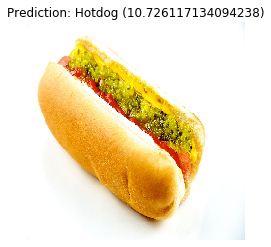

In [17]:
result = model.predict(hotdog[np.newaxis, ...])
predicted_class = np.argmax(result[0], axis=-1)

plt.imshow(hotdog)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: {} ({})".format(predicted_class_name.title(),result[0,predicted_class]))

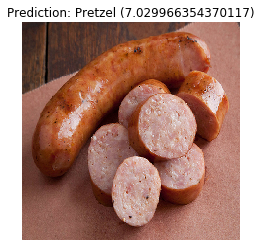

In [19]:
result = model.predict(maybe_hotdog[np.newaxis, ...])
predicted_class = np.argmax(result[0], axis=-1)

plt.imshow(maybe_hotdog)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: {} ({})".format(predicted_class_name.title(),result[0,predicted_class]))

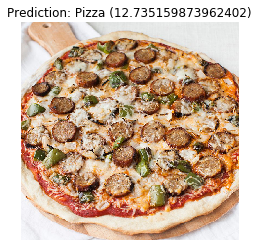

In [20]:
result = model.predict(not_hotdog[np.newaxis, ...])
predicted_class = np.argmax(result[0], axis=-1)

plt.imshow(not_hotdog)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: {} ({})".format(predicted_class_name.title(),result[0,predicted_class]))